## Adaptive time stepping methods

It is not uncommon for systems to have a combination of fast transients with otherwise slow behaviour. In general, we won't know when the transient occurs, or even it's rate of change!  

E.g.: The system $y(t) = \tanh(\frac{t-5}{0.1})-t$ has a slow decrease with a sharp bump. If the time step is small, the bump will be resolved, but it will take a long time for the quasi-linear parts. If the step is too large, the bump may be missed entirely!

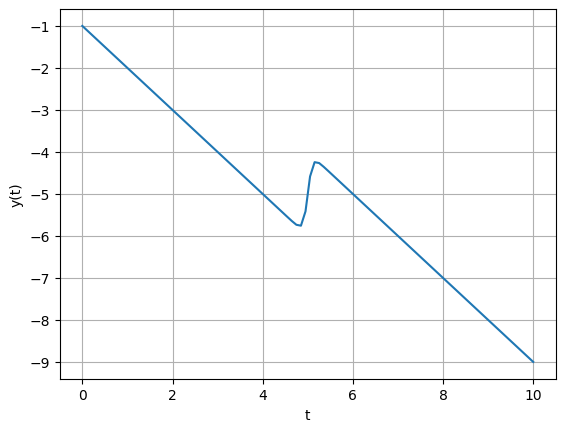

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a range of t values
t = np.linspace(0, 10, 100)

# Plot the function
plt.plot(t, np.tanh((t-5)/.1) - t)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.grid(True)
plt.show()

*Adaptive* time steppers automatically adjust their step size based on an estimate of the error.

If your timestep has an error $E_{current}$ with stepsize $h_{current}$, and you are aiming for an error tolerance $E_{goal}$ then you can update your step size with a formula like:

$$h_{new} = h_{current} \bigg|\frac{E_{goal}}{E_{current}} \bigg|^\alpha$$

where $\alpha$ is some user value (0.2 is a good choice).

There are remaining quesitons though:
* Would you reject the time step if $E_{current} \gt E_{tolerance}$ and repeat with a new timestep?
* Would you have a *meta* analysis of the solver method to 'catch' non-convergent cases?

There are a few methods to capture the error. Naturally, you don't want the error calculation to be overly burdomsome.
* Change step-size
* Change integration order
* Directly compare $y_i$ to $y_{i+1}$ or other properties of the solution.

### Step-halving methods

Step-halving methods compare the results of a full step to two half steps. For RK4, the error is calculated as:

$$E = y_{double \  step} - y_{single\  step} $$

for this RK4 scheme, one could correct higher accuracy estimate with $$y_{double \  step}^* = y_{double \  step} + \frac{E}{15}$$

Example: Integrate

$$
y^\prime = 4 e^{0.8t}-0.5y
$$ 

with $y(0) = 2$ from $t = 0\  to\  2$. The analytic answer is 14.84392.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, y):
  """The differential equation."""
  return 4 * np.exp(0.8 * x) - 0.5 * y

def rk4_step(f, x, y, h):
  """Takes a single RK4 step."""
  k1 = h * f(x, y)
  k2 = h * f(x + h/2, y + k1/2)
  k3 = h * f(x + h/2, y + k2/2)
  k4 = h * f(x + h, y + k3)
  return y + (k1 + 2*k2 + 2*k3 + k4) / 6

# Initial conditions
x0 = 0
y0 = 2
x_end = 2
h_initial = 2


y_onestep = rk4_step(f, x0, y0, 2)
print('One stpe with h=2 ', y_onestep)

y_t = rk4_step(f, x0, y0, 1)
y_twostep = rk4_step(f, x0+1, y_t, 1)
print('Two steps with h=1 ', y_twostep)

print('Approximate error is ', (y_twostep - y_onestep)/15, ' vs true error, ', 14.84392 - y_twostep)

One stpe with h=2  15.105846327501714
Two steps with h=1  14.8624835881192
Approximate error is  -0.016224182625500915  vs true error,  -0.018563588119199892


Note that to calculate this value we had to evaluate $f(x,y)$ 8 times.

### Runge-Kutta Fehlberg

Another approach is to compare different integration orders over the same step. This is made efficient by *reusing* function calls between the two approximations.

$$
\begin{array}{c|cccccc}
0 &  &  &  &  &  &  \\
\frac{1}{5} & \frac{1}{5} &  &  &  &  &  \\
\frac{3}{10} & \frac{3}{40} & \frac{9}{40} &  & & &  \\
\frac{3}{5} & \frac{3}{10} & -\frac{9}{10} & \frac{6}{5} &  &  &  \\
1 & -\frac{11}{54} & \frac{5}{2} & -\frac{70}{27} & \frac{35}{27} &  &  \\
\frac{7}{8} & \frac{1631}{55296} & \frac{175}{512} & \frac{575}{13824} & \frac{44275}{110592} & \frac{253}{4096} &  \\
\hline
 & \frac{37}{378} & 0 & \frac{250}{621} & \frac{125}{594} & 0 & \frac{512}{1771} \\
 & \frac{2825}{27648} & 0 & \frac{18575}{48384} & \frac{13525}{55296} & \frac{277}{14336} & \frac{1}{4} \\
\end{array}
$$

where the doubling of the last line means:

$$
\begin{align}
y_{i+1}^{(4)} &= y_i + h \left( \frac{37}{378} k_1 + \frac{250}{621} k_3 + \frac{125}{594} k_4 + \frac{512}{1771} k_6 \right) \\
y_{i+1}^{(5)} &= y_i + h \left( \frac{2825}{27648} k_1 + \frac{18575}{48384} k_3 + \frac{13525}{55296} k_4 + \frac{277}{14336} k_5 + \frac{1}{4} k_6 \right)
\end{align}$$

The error is then simply $y_{i+1}^{(5)} - y_{i+1}^{(4)}$

This is the method of choice for packaged tools. E.g.:

In [3]:
import numpy as np
from scipy.integrate import solve_ivp

def f(x, y):
  """The differential equation."""
  return 4 * np.exp(0.8 * x) - 0.5 * y

# Initial conditions
x0 = 0
y0 = 2
x_end = 2

# Solve the differential equation using solve_ivp
sol = solve_ivp(f, (x0, x_end), [y0], method='RK45')
print(sol)


# Extract the solution
y_numerical = sol.y[0][-1]

# Analytical solution (you might need to calculate this beforehand)
y_analytical = 14.84392

# Calculate the error
error = abs(y_numerical - y_analytical)

print(f"Numerical solution: {y_numerical}")
print(f"Error: {error}")

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  9.222e-02  1.014e+00  2.000e+00]
        y: [[ 2.000e+00  2.284e+00  6.279e+00  1.484e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 20
     njev: 0
      nlu: 0
Numerical solution: 14.844062517715555
Error: 0.00014251771555429116


### Direct comparison

A less elegant, but sometimes more pragmatic method is use other metrics to control the step size.

Following a time step, the rate of change can be calculated,  

$$\frac{dy}{dt} = \frac{y_{i+1}-y_i}{h}$$
from which a control on $\|\frac{dy}{dt}\|$ can be placed. E.g.: one could require that the Euclidian or $\infty$ norm be below a tolerance. This method controls the change in solution, rather than its error.  

An even more brute-force method may be to observe the efficiency of the solver. We know that nonlinear root finding with Newton's method converges quadratically near the root. By monitoring the Newton iterations at each timestep, one can assess if the solver is converging quadratically, or is taking too many iterations which may mean the new time step is too far from the previous one.
